# Summary

This notebook shows how to train Denoising Difussion Models.


# Hyperparams

In [ ]:
import numpy as np
import math
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

# data
diffusion_steps = 20
image_size = 32

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# optimization
batch_size = 64
num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-4
ema = 0.999

# Dataset

In [ ]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)

def prepare_dataset(split):
    return (
        tfds.load('mnist', split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(1)
        .shuffle(10000)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

# load dataset
train_dataset = prepare_dataset("train")
val_dataset = prepare_dataset("test")

# Denoising Network

We will use the [Residual U-Net](https://www.sciencedirect.com/science/article/abs/pii/S0924271620300149) model.

#TODO: can we use something simpler?

In [3]:
embedding_max_frequency = 1000.0
embedding_dims = 64

def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

## Custom Residual Network

In [4]:
def get_network_custom(image_size, block_depth=17, output_channels=1):
    # use the correct number of channels
    noisy_images = tf.keras.Input(shape=(image_size, image_size, output_channels))
    noise_variances = tf.keras.Input(shape=(1, 1, 1))

    e = tf.keras.layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = tf.keras.layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
    x = tf.keras.layers.Conv2D(32, kernel_size=1)(noisy_images)
    x = tf.keras.layers.Concatenate()([x, e])

    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation=tf.nn.relu)(x)
    for layers in range(2, block_depth+1):
        x = tf.keras.layers.BatchNormalization(center=False, scale=False)(x)
        x = tf.keras.layers.Conv2D(
            64, 3,
            padding='same', name='conv%d' % layers,
            activation=tf.keras.activations.swish,
            use_bias=False
        )(x)

    x = tf.keras.layers.Conv2D(output_channels, kernel_size=1, kernel_initializer="zeros")(x)
    return tf.keras.Model([noisy_images, noise_variances], x, name="simple-residual-net")

## Residual U-Net

In [5]:
widths = [32, 64, 96, 128]
block_depth = 2


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = tf.keras.layers.Conv2D(width, kernel_size=1)(x)
        x = tf.keras.layers.BatchNormalization(center=False, scale=False)(x)
        x = tf.keras.layers.Conv2D(
            width, kernel_size=3, padding="same", activation=tf.keras.activations.swish
        )(x)
        x = tf.keras.layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = tf.keras.layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = tf.keras.layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = tf.keras.layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    # use the correct number of channels
    noisy_images = tf.keras.Input(shape=(image_size, image_size, 1))
    noise_variances = tf.keras.Input(shape=(1, 1, 1))

    e = tf.keras.layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = tf.keras.layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = tf.keras.layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = tf.keras.layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = tf.keras.layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x)

    return tf.keras.Model([noisy_images, noise_variances], x, name="residual_unet")

# Difussion Model

In [6]:
class DiffusionModel(tf.keras.Model):
    def __init__(self, network):
        super().__init__()
        self.normalizer = tf.keras.layers.Normalization()
        self.network = network
        self.ema_network = tf.keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = tf.keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = tf.keras.metrics.Mean(name="i_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1
        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network
        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, steps):
        # reverse diffusion = sampling
        batch = initial_noise.shape[0]
        step_size = 1.0 / steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images
            diffusion_times = tf.ones((batch, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )

            # this new noisy image will be used in the next step
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
            next_diffusion_times
            )
            next_noisy_images = (
            next_signal_rates * pred_images + next_noise_rates * pred_noises
           )
        return pred_images

    def generate(self, num_images, steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 1))
        generated_images = self.reverse_diffusion(initial_noise, steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=images.shape)
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        return {m.name: m.result() for m in self.metrics}



## Complete Model

Chose one of the residual networks.

In [7]:
#network = get_network_custom(image_size,block_depth=10)
network = get_network(image_size,widths,block_depth)
print(network.summary())

Model: "residual_unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 1, 1)]            0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1, 1, 64)             0         ['input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           64        ['input_1[0][0]']             
                                                                                      

In [8]:
model = DiffusionModel(network)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
    loss=tf.keras.losses.mean_absolute_error,
)
model.normalizer.adapt(train_dataset)
model.fit(
    train_dataset,
    epochs=5,
)

Epoch 1/5
937/937 [==============================] - 72s 53ms/step - n_loss: 0.1263 - i_loss: 0.2892
Epoch 2/5
937/937 [==============================] - 54s 57ms/step - n_loss: 0.0849 - i_loss: 0.1805
Epoch 3/5
937/937 [==============================] - 51s 55ms/step - n_loss: 0.0761 - i_loss: 0.1593
Epoch 4/5
937/937 [==============================] - 51s 55ms/step - n_loss: 0.0717 - i_loss: 0.1473
Epoch 5/5
937/937 [==============================] - 52s 56ms/step - n_loss: 0.0688 - i_loss: 0.1415


# Visualize

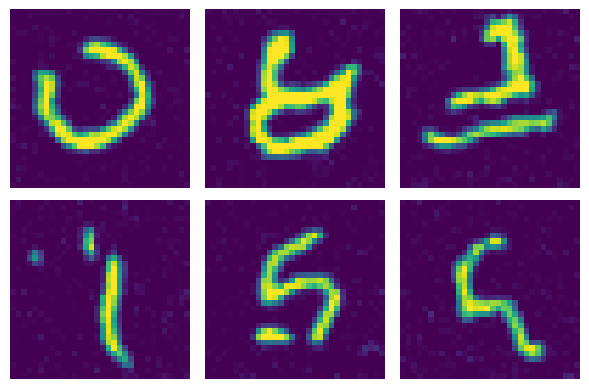

In [9]:
num_rows = 2
num_cols = 3

generated_images = model.generate(
    num_images=num_rows * num_cols,
    steps=diffusion_steps,
)

plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
for row in range(num_rows):
    for col in range(num_cols):
        index = row * num_cols + col
        plt.subplot(num_rows, num_cols, index + 1)
        plt.imshow(generated_images[index])
        plt.axis("off")

plt.tight_layout()

# Acknowledgments

Thanks to [Maciej Skórski](https://www.kaggle.com/mskorski) for creating [Denoising Difussion Model](https://www.kaggle.com/code/mskorski/denoising-difussion-model). It inspires the majority of the content in this chapter.